In [1]:
import pandas as pd
import numpy as np

# Charger la vidéo originale
video_path = "video/Puente_guambra2.mp4"

annot_path = "annot/Puente_guambra2"

# Charger les données du fichier CSV contenant les détections
data = pd.read_csv(f"{annot_path}_positions.csv")

data

,frame,id,class,conf,x,y,w,h,r
0,1,1,small vehicle,0.799707,3147.352783,1927.297485,68.076736,30.667210,0.702295
1,1,2,small vehicle,0.794483,3884.594971,1734.854004,69.598801,30.502787,3.096828
2,1,3,small vehicle,0.791207,3848.851318,297.630157,65.050095,28.272612,2.852607
3,1,4,small vehicle,0.789623,3912.966064,234.005264,57.210426,27.760963,2.846446
4,1,5,small vehicle,0.784193,3054.614502,462.138000,67.955238,29.348560,2.846578
...,...,...,...,...,...,...,...,...,...
836095,2787,296,small vehicle,0.004736,212.654419,1326.082275,53.121117,26.460634,1.657638
836096,2787,297,large vehicle,0.004669,2331.807861,1938.676880,65.139488,26.903704,1.416893
836097,2787,298,large vehicle,0.004669,1721.948975,548.927734,128.718628,33.304638,1.330535
836098,2787,299,small vehicle,0.004653,2545.928223,638.934082,46.103313,25.143497,2.825501


## Tracking based on the distance of the n previous frame

Can have differents objects with the same id on the same frame

In [2]:
class MaxId:
    def __init__(self):
        self.max_id = 0
    def incr(self):
        self.max_id += 1
        return self.max_id

In [3]:
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from itertools import combinations
from scipy.spatial import distance

pd.options.mode.chained_assignment = None  # default='warn'

threshold = 10
look_back = 20

max_id = MaxId()


tracking_data = []


min_frame = data['frame'].min()
max_frame = data['frame'].max()

# Lire la vidéo frame par frame
for frame_number in tqdm(range(min_frame, max_frame + 1)):

    # Filtrer les détections pour le frame actuel
    detections_in_frame = data[data['frame'] == frame_number]
    
    if frame_number == min_frame:
        tracking_data = detections_in_frame.rename(columns={'id': 'track_id'})
        tracking_data['track_id'] = [max_id.incr() for _ in range(len(tracking_data))]
    else:

        
        track_list = tracking_data[(tracking_data['frame'] < frame_number) & (tracking_data['frame'] > frame_number-look_back-1)]
        
        actual_pos = detections_in_frame[['x', 'y']].values
        
        dist = cdist(actual_pos, track_list[['x', 'y']])
        
        # print(np.where(dist<threshold))
        
        indexs = []
        
        
        ids = track_list['track_id'].values
        
        
        new_id = np.zeros(len(detections_in_frame))
        
        for idx in range(len(dist)):
            argmin = np.argmin(dist[idx])
            
            
            if dist[idx, argmin] < threshold:
                new_id[idx] = ids[argmin]
            else:
                new_id[idx] = max_id.incr()
                
        for idx in np.unique(new_id):
            k = np.where(new_id == idx)[0]
            
            if k.size > 1:
                
                for (i, j) in combinations(k, 2):
                    if distance.euclidean(actual_pos[i], actual_pos[j]) >= threshold:
                        
                        if np.min(dist[i]) < np.min(dist[j]):
                            new_id[j] = max_id.incr() if new_id[j] == idx else new_id[j]
                        else:
                            new_id[i] = max_id.incr() if new_id[i] == idx else new_id[i]
                    else:
                        if new_id[i] == idx:
                            new_id[j] = new_id[i]
                        else:
                            new_id[i] = new_id[j]

                
        detections_in_frame['track_id'] = new_id
 
        # detections_in_frame.iloc[x]['id'] = track_list.iloc[y]['id']
            
        tracking_data = pd.concat([tracking_data, detections_in_frame])
            
tracking_data['id'] = tracking_data['track_id'].astype(int)
tracking_data.drop(columns=['track_id'], inplace=True)

tracking_data.to_csv(f"{annot_path}_tracking.csv", index=False)

tracking_data

  0%|          | 0/2787 [00:00<?, ?it/s]

,frame,class,conf,x,y,w,h,r,id
0,1,small vehicle,0.799707,3147.352783,1927.297485,68.076736,30.667210,0.702295,1
1,1,small vehicle,0.794483,3884.594971,1734.854004,69.598801,30.502787,3.096828,2
2,1,small vehicle,0.791207,3848.851318,297.630157,65.050095,28.272612,2.852607,3
3,1,small vehicle,0.789623,3912.966064,234.005264,57.210426,27.760963,2.846446,4
4,1,small vehicle,0.784193,3054.614502,462.138000,67.955238,29.348560,2.846578,5
...,...,...,...,...,...,...,...,...,...
836095,2787,small vehicle,0.004736,212.654419,1326.082275,53.121117,26.460634,1.657638,14373
836096,2787,large vehicle,0.004669,2331.807861,1938.676880,65.139488,26.903704,1.416893,14342
836097,2787,large vehicle,0.004669,1721.948975,548.927734,128.718628,33.304638,1.330535,14356
836098,2787,small vehicle,0.004653,2545.928223,638.934082,46.103313,25.143497,2.825501,10239


## Groupe the different objects with the same id per frame

In [4]:
tracking_data = pd.read_csv(f"{annot_path}_tracking.csv")

detection_counts = tracking_data.groupby(['id', 'class']).size().reset_index(name='Counts')
most_detected_class = detection_counts.loc[detection_counts.groupby('id')['Counts'].idxmax()]
tracking_data = tracking_data.merge(most_detected_class[['id', 'class']], on='id', suffixes=('', '_avg')).sort_values(['id', 'frame'])

def check_class(classes):
    assert classes.nunique() == 1, classes.unique()
    return classes.unique()[0]

data_process = tracking_data.groupby(['id', 'frame']).agg({
    'class_avg': check_class,
    'x': 'mean',
    'y': 'mean',
    'w': 'mean',
    'h': 'mean',
    'r': 'mean',
    'conf': 'mean',
}).reset_index().rename(columns={'class_avg': 'class'}).sort_values(['id', 'frame'])



## Filter out low confidence detections per id in average

In [5]:
# Filter out low confidence detections per id in average
min_conf_per_id = 0.05


conf = data_process.groupby('id')['conf'].mean()
ids = conf[conf > min_conf_per_id].index
data_process = data_process[data_process['id'].isin(ids)]
data_process.to_csv(f"{annot_path}_tracking_process.csv", index=False)

## Calculate the velocity for each id (pixel/frame)

In [6]:
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform

data = pd.read_csv(f"{annot_path}_tracking_process.csv")


for id in data['id'].unique():
    dp = data[data['id']==id]

    diff = dp[['x', 'y', 'frame']].diff()
    
    vect = diff[['x', 'y']]/diff['frame'].values.reshape(-1, 1)
    
    
    speed = np.linalg.norm(vect.fillna(0), axis=1)
    
    data.loc[dp.index, 'velocity'] = speed

data.head()


,id,frame,class,x,y,w,h,r,conf,velocity
0,1,1,small vehicle,3147.352783,1927.297485,68.076736,30.667210,0.702295,0.799707,0.000000
1,1,2,small vehicle,3147.352783,1927.297485,68.076736,30.667210,0.702295,0.799707,0.000000
2,1,3,small vehicle,3147.352783,1927.297485,68.076729,30.667208,0.702295,0.799707,0.000000
3,1,4,small vehicle,3147.224609,1927.243652,67.970299,30.453020,0.700536,0.797745,0.139020
4,1,5,small vehicle,3146.747803,1927.184448,68.213364,30.560076,0.698487,0.811042,0.480468


Histograme of velocity

count    549323.000000
mean          1.336342
std           2.198291
min           0.000000
25%           0.175198
50%           0.395908
75%           1.279935
max         173.037397
Name: velocity, dtype: float64

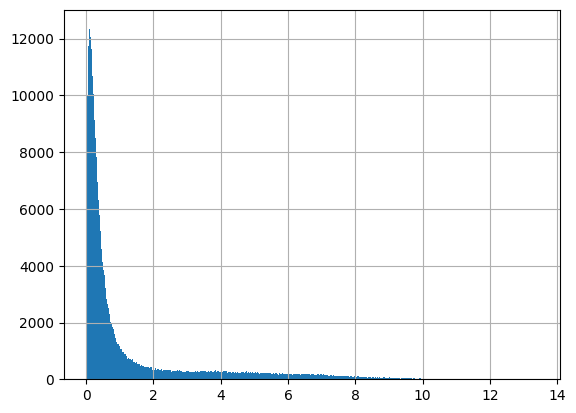

In [7]:
data['velocity'].clip(0, data['velocity'].quantile(0.999)).hist(bins=1000)
data['velocity'].describe()

In [8]:
min_conf = 0.20
max_vel = data['velocity'].quantile(0.995)
print(min_conf, max_vel)

id = data[data['velocity'] > data["velocity"].quantile(0.9)]['id'].unique()

idx = data[data['id'].isin(id)].groupby('id')['conf'].mean() < min_conf

data = data[~data['id'].isin(idx[idx].index)]

data.to_csv(f"{annot_path}_tracking_velocity.csv", index=False)

0.2 9.383781164946774


In [9]:
data['velocity'].describe()

count    443743.000000
mean          1.250391
std           2.140511
min           0.000000
25%           0.159105
50%           0.346450
75%           1.003811
max         173.037397
Name: velocity, dtype: float64

In [10]:
import cv2

tracking_data = pd.read_csv(f"{annot_path}_tracking_process.csv")
# tracking_data = data_process


class_colors = {
    'small vehicle': (0, 255, 255),
    'large vehicle': (255, 255, 0),
    # Ajouter d'autres classes et couleurs au besoin
}



def draw_obb(img, cx, cy, w, h, angle, class_name, confidence, id, points, colors=class_colors, thickness=2):
    rect = ((cx, cy), (w, h), angle*180/np.pi)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(img, [box], 0, colors[class_name], thickness)
    cv2.putText(img, f"{class_name} ({confidence:.2f}) id: {id}", (int(cx), int(cy) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_name], 2)
    # cv2.polylines(img, [points], isClosed=False, color=colors[class_name], thickness=thickness)  

cap = cv2.VideoCapture(video_path)

last_positions = []


ids = data[data['velocity'] > data["velocity"].quantile(0.9)*2]['id'].unique()
# ids = sdp[sdp['sdp'] <-1]['id'].unique()

# Lire la vidéo frame par frame
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break
    

    frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    
    
    detections_in_frame = tracking_data[tracking_data['frame'] == frame_number]
        
    # detections_in_frame = detections_in_frame[detections_in_frame['id'].isin(ids)]
    
    for index, row in detections_in_frame.iterrows():
        cx, cy, w, h, r = row['x'], row['y'], row['w'], row['h'], row['r']
        class_name, confidence = row['class'], row['conf']
        
        confidence = tracking_data[tracking_data['id'] == row['id']]['conf'].mean() 

        
        id = row['id']
        
        track =  tracking_data[(tracking_data['frame'] <= frame_number) & (tracking_data['id'] == id)][['x', 'y']].values

        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        
        draw_obb(img=frame, cx=cx, cy=cy, w=w, h=h, angle=r, class_name=class_name, confidence=confidence, id=id, points=points)
        
    cv2.imshow('frame', cv2.resize(frame, (1920, 1080)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break



KeyboardInterrupt: 

: 